In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
model_builder = keras.applications.xception.Xception
img_size = (180, 180)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_9"

# The local path to our target image
img_path = 'Datasets\Pneumonia\Viral Pneumonia\images\person17_virus_48.jpeg'

# display(Image(img_path))

In [3]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [4]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, reduction=tf.keras.losses.Reduction.AUTO, name="custom_loss"):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))


custom_loss = CustomLoss()

In [5]:
from keras.models import load_model
model = load_model("heuristic_Merged.h5",custom_objects={'CustomLoss': CustomLoss})

In [6]:
def prediction__(image):
    predictions = model.predict(image)
    i = np.argmax(predictions)
    labels = ['Normal', 'COVID', 'Viral Pneumonia']
    print(predictions[0])
    
    predicted_label_index = np.argmax(predictions[0])
    print(predicted_label_index)
    predicted_label = labels[i]
    return predicted_label


1/1 [==============================] - 0s 400ms/step


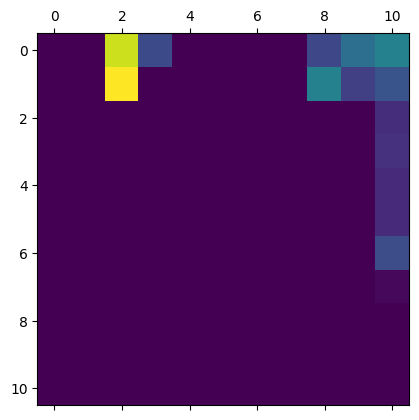

In [7]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [8]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


# save_and_display_gradcam(img_path, heatmap)

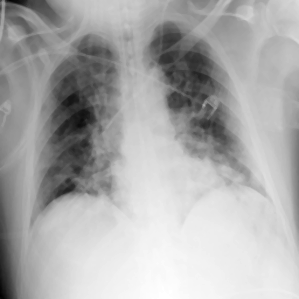

1/1 [==============================] - 0s 31ms/step
[-1.6428901  1.4424987 -3.7273748]
1
Predicted: COVID


In [9]:
# img_path = r"Datasets\COVID-19_Radiography_Dataset\Normal\images\Normal-24.png"
# img_path = r"Datasets\COVID-19_Radiography_Dataset\Normal\images\Normal-27.png"
# img_path = r"Datasets\COVID-19_Radiography_Dataset\Normal\images\Normal-29.png"
# img_path = r"Datasets\COVID-19_Radiography_Dataset\Normal\images\Normal-1112.png"
# img_path = r"Datasets\COVID-19_Radiography_Dataset\Normal\images\Normal-4053.png"
# img_path = r"Datasets\COVID-19_Radiography_Dataset\Normal\images\Normal-682.png"
#covid


# img_path = r"Datasets\COVID-19_Radiography_Dataset\COVID\images\COVID-55.png"
# img_path = r"CS+MEDIAN\COVID-19_Radiography_Dataset\COVID\images\CS+MEDIAN-COVID-56.png"

# img_path = r"Datasets\COVID-19_Radiography_Dataset\COVID\images\COVID-2334.png"
# img_path = r"CS+MEDIAN\COVID-19_Radiography_Dataset\COVID\images\CS+MEDIAN-COVID-1022.png"
img_path = r"CS+MEDIAN\COVID-19_Radiography_Dataset\COVID\images\CS+MEDIAN-COVID-921.png"
#Viral
# img_path = r"Datasets\COVID-19_Radiography_Dataset\Viral Pneumonia\images\Viral Pneumonia-10.png"
# img_path = r"CL+MEDIAN\Pneumonia\Viral Pneumonia\images\CLAHE+MEDIAN-person1_virus_8.jpeg"
# img_path = r"CL+MEDIAN\Pneumonia\Viral Pneumonia\images\CLAHE+MEDIAN-person76_virus_138.jpeg"
display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# preds = model.predict(img_array)
print("Predicted:", prediction__(img_array))

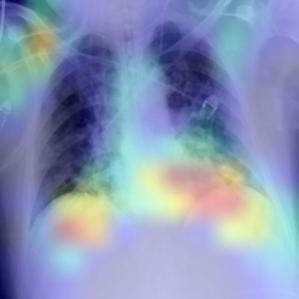

In [10]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(img_path, heatmap, 'covid-6.jpg')